# Data Preparation

In [2]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("XYZloan_default_selected_vars.csv")

In [4]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(
     data, test_size=0.40, random_state=42)

In [5]:
var = pd.DataFrame(train.dtypes).reset_index()
var.columns = ['varname','dtype'] 
var['source'] = var['varname'].str[:2]
var.head()

,varname,dtype,source
0,Unnamed: 0.1,int64,Un
1,Unnamed: 0,int64,Un
2,id,int64,id
3,loan_default,int64,lo
4,AP001,int64,AP


In [6]:
# "AP004" is a bad data field and should be removed.
MB_list = list(var[var['source']=='MB']['varname'])
AP_list = list(var[(var['source']=='AP') & (var['varname']!='AP004')]['varname'])
TD_list = list(var[var['source']=='TD']['varname'])
CR_list = list(var[var['source']=='CR']['varname'])
PA_list = list(var[var['source']=='PA']['varname'])
CD_list = list(var[var['source']=='CD']['varname'])
AP_list

['AP001', 'AP002', 'AP003', 'AP005', 'AP006', 'AP007', 'AP008', 'AP009']

In [7]:
train['loan_default'].value_counts(dropna=False)

0    38736
1     9264
Name: loan_default, dtype: int64

In [8]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,16 hours 5 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_vickyma_rxjfot
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,589 Mb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


# GBM

Gradient Boosting Machine is a machine learning algorithm used for both classification and regression tasks. It builds an ensemble of decision trees in a sequential manner, where each tree corrects the errors of the previous ones. This results in a powerful and accurate predictive model. GBM is an example of an ensemble learning technique, specifically boosting. GBM can be used as a one-class classifier where it learns to represent normal patterns and detects anomalies as instances that deviate from the learned normal behavior.

## 10% data test

In [9]:
target='loan_default'

In [10]:
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [11]:
predictors = CR_list + TD_list + AP_list + MB_list + CR_list + PA_list 

In [12]:
from h2o.estimators import H2OGradientBoostingEstimator
GBM_modl = H2OGradientBoostingEstimator(
        model_id = 'GBM_modl',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)

GBM_modl.train(predictors,target,training_frame=train_hex)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_modl


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    300                300                         70595                  5            5            5             6             24            12.82

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.09058185045859571
RMSE: 0.3009681884495365
MAE: 0.22271322892625903
RMSLE: 0.2084731228293551
Mean Residual Deviance: 0.09058185045859571

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.158421612494745
RMSE: 0.398022125634675
MAE: 0.29660107640694827
RMSLE: 0.2829786895619104
Mean Residual Deviance: 0.158421612494745

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.296355   0.0112964   0.28293       0.293431      0.30351       0.295077      0.285474      0.316927      0.288571      0.301013      0.286573      0.31004
mean_residual_deviance  0.158156   0.011848    0.14551       0.154395      0.169995      0.159309      0.151883      0.178561      0.144862      0.160015      0.146031      0.170998
mse                     0.158156   0.011848    0.14551       0.154395      0.169995      0.159309      0.151883      0.178561      0.144862      0.160015      0.146031      0.170998
r2                      -0.041358  0.0324306   -0.023264     -0.0479243    -0.0720415    -0.00177828   0.0128334     -0.0366058    -0.0783108    -0.0589815    -0.082428     -0.0250793
residual_deviance       0.158156   0.011848    0.14551       0.154395      0.169995      0.159309      0.151883      0.178561      0.144862      0.160015      0.146031      0.170998
rmse                    0.39744    0.0148061   0.381458      0.392931      0.412305      0.399135      0.389722      0.422564      0.380608      0.400018      0.38214       0.413519
rmsle                   0.282646   0.00848612  0.272772      0.279808      0.292811      0.280889      0.274899      0.297327      0.276101      0.284432      0.276214      0.291203

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------  -----------------  -------------------  -------------------  -------------------
     2023-11-30 13:18:15  33.470 sec  0.0                0.3906456105673768   0.305207986111116    0.1526039930555586
     2023-11-30 13:18:15  33.498 sec  1.0                0.38833110318876585  0.3033101474866271   0.1508010457038039
     2023-11-30 13:18:15  33.513 sec  2.0                0.38633485690413844  0.30159036357887087  0.14925462165914113
     2023-11-30 13:18:15  33.526 sec  3.0                0.38454946442222215  0.2999653066508472   0.14787829058741792
     2023-11-30 13:18:15  33.540 sec  4.0                0.38298992345810945  0.2984721589119484   0.14668128147044854
     2023-11-30 13:18:15  33.554 sec  5.0                0.38161258644733187  0.2971229132761558   0.14562816613502236
     2023-11-30 13:18:15  33.567 sec  6.0                0.38048864104086216  0.2959717635375758   0.14477160596112204
     2023-11-30 13:18:15  33.581 sec  7.0                0.379056307390772    0.29454700941840806  0.14368368417272745
     2023-11-30 13:18:15  33.594 sec  8.0                0.3779531691314832   0.29337721028830854  0.14284859805653

In [13]:
def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)
    
    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')
    
    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



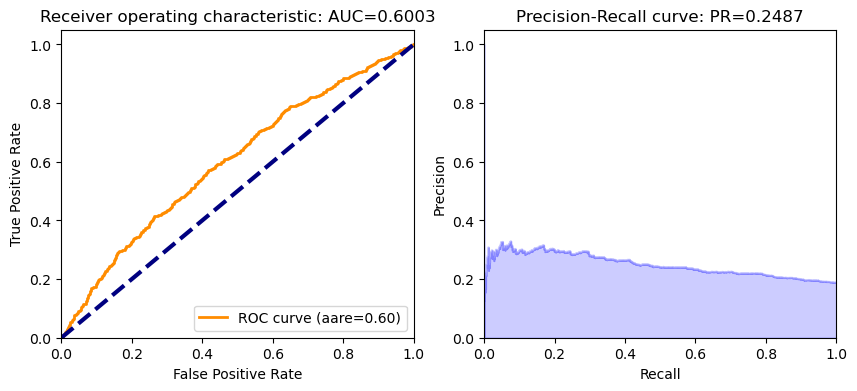

In [14]:
ROC_AUC(GBM_modl,test_hex,'loan_default')

In [15]:
def createGains(model):
    predictions = model.predict(test_hex)
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)

createGains(GBM_modl)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,100,220,320,100,220,0.17,0.08,60.0,1.67,9.0,31.25
1,320,79,241,640,179,461,0.30,0.18,120.0,1.49,12.0,27.97
2,320,70,250,960,249,711,0.42,0.27,180.0,1.38,15.0,25.94
3,320,58,262,1280,307,973,0.51,0.37,240.0,1.28,14.0,23.98
4,320,60,260,1600,367,1233,0.61,0.47,300.0,1.22,14.0,22.94
5,320,58,262,1920,425,1495,0.71,0.57,360.0,1.18,14.0,22.14
6,320,54,266,2240,479,1761,0.80,0.68,420.0,1.14,12.0,21.38
7,320,43,277,2560,522,2038,0.87,0.78,480.0,1.09,9.0,20.39
8,320,39,281,2880,561,2319,0.94,0.89,540.0,1.04,5.0,19.48


# Best Model using Grid-Search

In [17]:
import h2o
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch

gbm_params1 = {'learn_rate': [0.01, 0.1],
                'max_depth': [3, 5, 9],
                'sample_rate': [0.8, 1.0],
                'col_sample_rate': [0.2, 0.5, 1.0],
                'ntrees' : [100,200,300],
                'min_rows' :[50,100]
               }

gbm_model = H2OGradientBoostingEstimator()

# Perform grid search
grid = H2OGridSearch(gbm_model, gbm_params1)
grid.train(x=predictors, y=target, training_frame=train_hex)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,col_sample_rate,learn_rate,max_depth,min_rows,ntrees,sample_rate,model_ids,residual_deviance
,1.0,0.1,9.0,50.0,300.0,0.8,Grid_GBM_Key_Frame__upload_86be2532574f4ef88a2baf4c40df4b01.hex_model_python_1701310331368_5_model_90,0.0347114
,1.0,0.1,9.0,50.0,300.0,1.0,Grid_GBM_Key_Frame__upload_86be2532574f4ef88a2baf4c40df4b01.hex_model_python_1701310331368_5_model_198,0.0391387
,0.5,0.1,9.0,50.0,300.0,0.8,Grid_GBM_Key_Frame__upload_86be2532574f4ef88a2baf4c40df4b01.hex_model_python_1701310331368_5_model_89,0.0405663
,0.5,0.1,9.0,50.0,300.0,1.0,Grid_GBM_Key_Frame__upload_86be2532574f4ef88a2baf4c40df4b01.hex_model_python_1701310331368_5_model_197,0.0423130
,0.2,0.1,9.0,50.0,300.0,0.8,Grid_GBM_Key_Frame__upload_86be2532574f4ef88a2baf4c40df4b01.hex_model_python_1701310331368_5_model_88,0.0478705
,0.2,0.1,9.0,50.0,300.0,1.0,Grid_GBM_Key_Frame__upload_86be2532574f4ef88a2baf4c40df4b01.hex_model_python_1701310331368_5_model_196,0.0482656
,1.0,0.1,9.0,50.0,200.0,0.8,Grid_GBM_Key_Frame__upload_86be2532574f4ef88a2baf4c40df4b01.hex_model_python_1701310331368_5_model_54,0.0542897
,1.0,0.1,9.0,50.0,200.0,1.0,Grid_GBM_Key_Frame__upload_86be2532574f4ef88a2baf4c40df4b01.hex_model_python_1701310331368_5_model_162,0.0549892
,0.5,0.1,9.0,50.0,200.0,1.0,Grid_GBM_Key_Frame__upload_86be2532574f4ef88a2baf4c40df4b01.hex_model_python_1701310331368_5_model_161,0.0564932
,0.5,0.1,9.0,50.0,200.0,0.8,Grid_GBM_Key_Frame__upload_86be2532574f4ef88a2baf4c40df4b01.hex_model_python_1701310331368_5_model_53,0.0581300


In [18]:
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
def ROC_AUC_index(my_result,df,target):
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)
    return roc_auc

def PR_index(my_result,df,target):
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
    average_precision = average_precision_score(y_actual,y_pred)
    return average_precision

ROC_AUC_index(grid.get_grid()[0],test_hex,'loan_default')

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


0.5998852564102564

In [19]:
best_roc_index = 0
best_pr_index = 0
best_roc_auc = 0
best_pr_score = 0
for i in range(len(grid.get_grid())):
  inter_grid=grid.get_grid()[i]

# Evaluate ROC AUC
  roc_auc = ROC_AUC_index(inter_grid, test_hex, target)
  if roc_auc > best_roc_auc:
      best_roc_auc = roc_auc
      best_roc_index = i

# Evaluate PR index
  pr_score = PR_index(inter_grid, test_hex, target)
  if pr_score > best_pr_score:
      best_pr_score = pr_score
      best_pr_index = i

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |████████████████████████

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |████████████████████████

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |████████████████████████

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |████████████████████████

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |████████████████████████

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [20]:
# Print the results
print("Best PR Index:", best_pr_index)
print("Best PR Score:", best_pr_score)

Best PR Index: 153
Best PR Score: 0.2899230957366722


In [21]:
best_gbm_model = grid.get_grid()[153]
best_gbm_model

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: Grid_GBM_Key_Frame__upload_86be2532574f4ef88a2baf4c40df4b01.hex_model_python_1701310331368_5_model_67


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    200                200                         84325                  6            9            8.535         19            32            27.34

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.136300152660363
RMSE: 0.369188505590793
MAE: 0.2839931153793198
RMSLE: 0.25719882789799037
Mean Residual Deviance: 0.136300152660363

Scoring History: 
     timestamp            duration          number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------------  -----------------  -------------------  -------------------  -------------------
     2023-11-30 13:22:41  2 min 20.630 sec  0.0                0.3906456105673768   0.305207986111116    0.1526039930555586
     2023-11-30 13:22:41  2 min 20.695 sec  1.0                0.390452992768887    0.30505572332069275  0.15245353956218055
     2023-11-30 13:22:41  2 min 20.714 sec  2.0                0.39027943400370074  0.3049073961408188   0.152318036606249
     2023-11-30 13:22:41  2 min 20.728 sec  3.0                0.3900940946555575   0.3047401078076412   0.15217340268513907
     2023-11-30 13:22:41  2 min 20.758 sec  4.0                0.38988758256712785  0.3045526439417154   0.15201232704003895
     2023-11-30 13:22:41  2 min 20.789 sec  5.0                0.3896943226042408   0.304425002882878    0.15186166506997809
     2023-11-30 13:22:41  2 min 20.816 sec  6.0                0.389514456597026    0.30426889661699535  0.15172151189807645
     2023-11-30 13:22:41  2 min 20.858 sec  7.0                0.3893212847527205   0.30410155615769324  0.1515710627615089
     2023-11-30 13:22:41  2 min 20.904 sec  8.0                0.3891357143197434   0.303928312935556    0.15142660415913695
     2023-11-30 13:22:41  2 min 20.929 sec  9.0                0.38893539888570444  0.30376261410924293  0.151270744506382
---  ---                  ---               ---                ---                  ---                  ---
     2023-11-30 13:22:45  2 min 24.462 sec  168.0              0.3714681557485722   0.2864139915599177   0.13798859073524553
     2023-11-30 13:22:45  2 min 24.482 sec  169.0              0.37140768754061354  0.28634839293158926  0.13794367036426602
     2023-11-30 13:22:45  2 min 24.501 sec  170.0              0.37134486105260056  0.28625279702013356  0.13789700583017522
     2023-11-30 13:22:45  2 min 24.522 sec  171.0              0.37127798197738976  0.28618534687052793  0.13784733990120296
     2023-11-30 13:22:45  2 min 24.544 sec  172.0              0.3711917176569939   0.2860964745632373   0.13778329125714947
     2023-11-30 13:22:45  2 min 24.564 sec  173.0              0.3711172845345735   0.28599092735365655  0.13772803888031557
     2023-11-30 13:22:45  2 min 24.584 sec  174.0              0.37105304356767477  0.28591601544059814  0.13768036114083476
     2023-11-30 13:22:45  2 min 24.604 sec  175.0              0.37097241848807855  0.2858241331942069   0.1376205352788941
     2023-11-30 13:22:45  2 min 24.622 sec  176.0              0.37086548470940867  0.28575399846614646  0.13754120774874465
     2023-11-30 13:22:45  2 min 25.005 sec  200.0              0.369188505590793    0.2839931153793198   0.136300152660363
[178 rows x 7 columns]


Variable Importances: 
variable    relative_importance    scaled_importance     percentage
----------  ---------------------  --------------------  ---------------------
MB007       572.7284545898438      1.0                   0.15326

In [22]:
createGains(best_gbm_model)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,104,216,320,104,216,0.17,0.08,60.0,1.73,9.0,32.50
1,320,94,226,640,198,442,0.33,0.17,120.0,1.65,16.0,30.94
2,320,76,244,960,274,686,0.46,0.26,180.0,1.52,20.0,28.54
3,320,60,260,1280,334,946,0.56,0.36,240.0,1.39,20.0,26.09
4,320,62,258,1600,396,1204,0.66,0.46,300.0,1.32,20.0,24.75
5,320,54,266,1920,450,1470,0.75,0.57,360.0,1.25,18.0,23.44
6,320,51,269,2240,501,1739,0.84,0.67,420.0,1.19,17.0,22.37
7,320,42,278,2560,543,2017,0.90,0.78,480.0,1.13,12.0,21.21
8,320,30,290,2880,573,2307,0.96,0.89,540.0,1.06,7.0,19.90


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



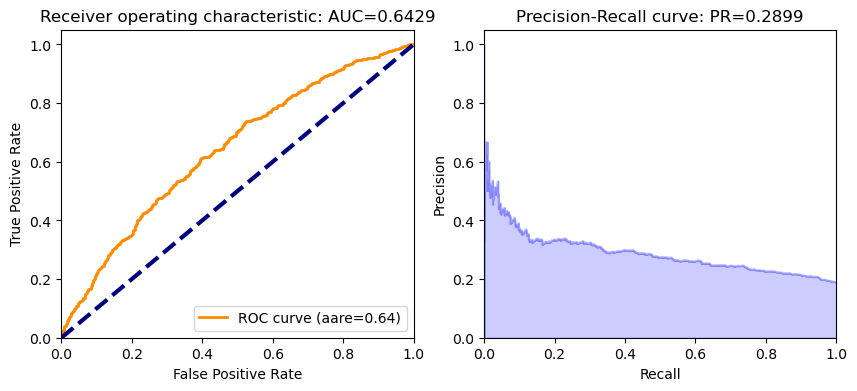

In [23]:
ROC_AUC(best_gbm_model,test_hex,'loan_default')

In [25]:
best_gbm_model_params = best_gbm_model.params
learn_rate_value = best_gbm_model_params['learn_rate']['actual']
max_depth_value = best_gbm_model_params['max_depth']['actual']
sample_rate_value = best_gbm_model_params['sample_rate']['actual']
col_sample_rate_value = best_gbm_model_params['col_sample_rate']['actual']
ntrees_value = best_gbm_model_params['ntrees']['actual']
min_rows = best_gbm_model_params['min_rows']['actual']
print("learn_rate =",learn_rate_value)
print("max_depth = ", max_depth_value)
print("sample_rate =", sample_rate_value)
print("col_sample_rate =",col_sample_rate_value)
print("ntrees = ", ntrees_value)
print("min_rows =", min_rows)

learn_rate = 0.01
max_depth =  9
sample_rate = 0.8
col_sample_rate = 0.2
ntrees =  200
min_rows = 100.0


## GBM on whole dataset

In [26]:
train_hex2 = h2o.H2OFrame(train)
test_hex2 = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [27]:
gbm_v2 = H2OGradientBoostingEstimator(
        model_id = 'gbm_v2',
        learn_rate=0.01,
        max_depth=9,
        sample_rate=0.8,
        col_sample_rate=0.2,
        ntrees=200,
        min_rows=100,
        seed=1234)
gbm_v2.train(predictors,target,training_frame=train_hex2)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: gbm_v2


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    200                200                         419595                 9            9            9             91            198           143.415

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.14023155196045212
RMSE: 0.37447503516316294
MAE: 0.29037845569841253
RMSLE: 0.2613564681935367
Mean Residual Deviance: 0.14023155196045212

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------  -----------------  -------------------  -------------------  -------------------
     2023-11-30 13:47:39  0.020 sec   0.0                0.39465301215116094  0.311502000000036    0.15575099999998437
     2023-11-30 13:47:40  0.255 sec   1.0                0.39443288100901563  0.3113205150940145   0.15557729762107228
     2023-11-30 13:47:40  0.320 sec   2.0                0.39422693648812085  0.3111627804804593   0.15541487745280885
     2023-11-30 13:47:40  0.381 sec   3.0                0.39401514726932674  0.3109935668092221   0.15524793627766922
     2023-11-30 13:47:40  0.441 sec   4.0                0.3937914338032096   0.3108103949797029   0.1550716933367876
     2023-11-30 13:47:40  0.517 sec   5.0                0.39358261204675554  0.31063563377565395  0.15490727250554687
     2023-11-30 13:47:41  1.585 sec   6.0                0.39337203671839355  0.3104597953182335   0.15474155927197716
     2023-11-30 13:47:41  1.650 sec   7.0                0.3931692453066123   0.3102970674217989   0.15458205545497108
     2023-11-30 13:47:41  1.709 sec   8.0                0.3929746894132735   0.31013365514855834  0.1544291065194588
     2023-11-30 13:47:41  1.765 sec   9.0                0.3927785091209044   0.3099678951036185   0.15427495722724036
---  ---                  ---         ---                ---                  ---                  ---
     2023-11-30 13:47:47  7.654 sec   36.0               0.387994246501688    0.3057443948062137   0.15053953531841266
     2023-11-30 13:47:51  11.673 sec  51.0               0.38592345451277155  0.30367800254561006  0.14893691274307125
     2023-11-30 13:47:55  15.682 sec  68.0               0.3838999291930855   0.30157481049078827  0.14737915563445608
     2023-11-30 13:47:59  20.086 sec  82.0               0.3824587333837116   0.3000042716418393   0.146274682741473
     2023-11-30 13:48:04  24.951 sec  102.0              0.38064532479428237  0.2979653341351077   0.1448908632877447
     2023-11-30 13:48:09  29.604 sec  121.0              0.3791246759444165   0.29615525363665074  0.14373551990995884
     2023-11-30 13:48:13  33.734 sec  140.0              0.3778028683302902   0.2945818564631045   0.1427350073185946
     2023-11-30 13:48:17  37.744 sec  165.0              0.37629051185532963  0.29267250282270835  0.14159454931234597
     2023-11-30 13:48:21  41.795 sec  183.0              0.37533208880398855  0.29147757778254646  0.14087417688596515
     2023-11-30 13:48:25  45.670 sec  200.0              0.37447503516316294  0.29037845569841253  0.14023155196045212
[28 rows x 7 columns]


Variable Importances: 
variable    relative_importance    scaled_importance    percentage
----------  ---------------------  -------------------  --------------------
MB007       5046.107421875         1.0                  0.14897901206244754
AP003       3623.360107421875      0.7180505297438813   0.10697445853216055
TD013       2757.843505859375      0.5465288935197962   0.08142133462016182
TD009       2314.943603515625      0.4587582883155217   0.0683

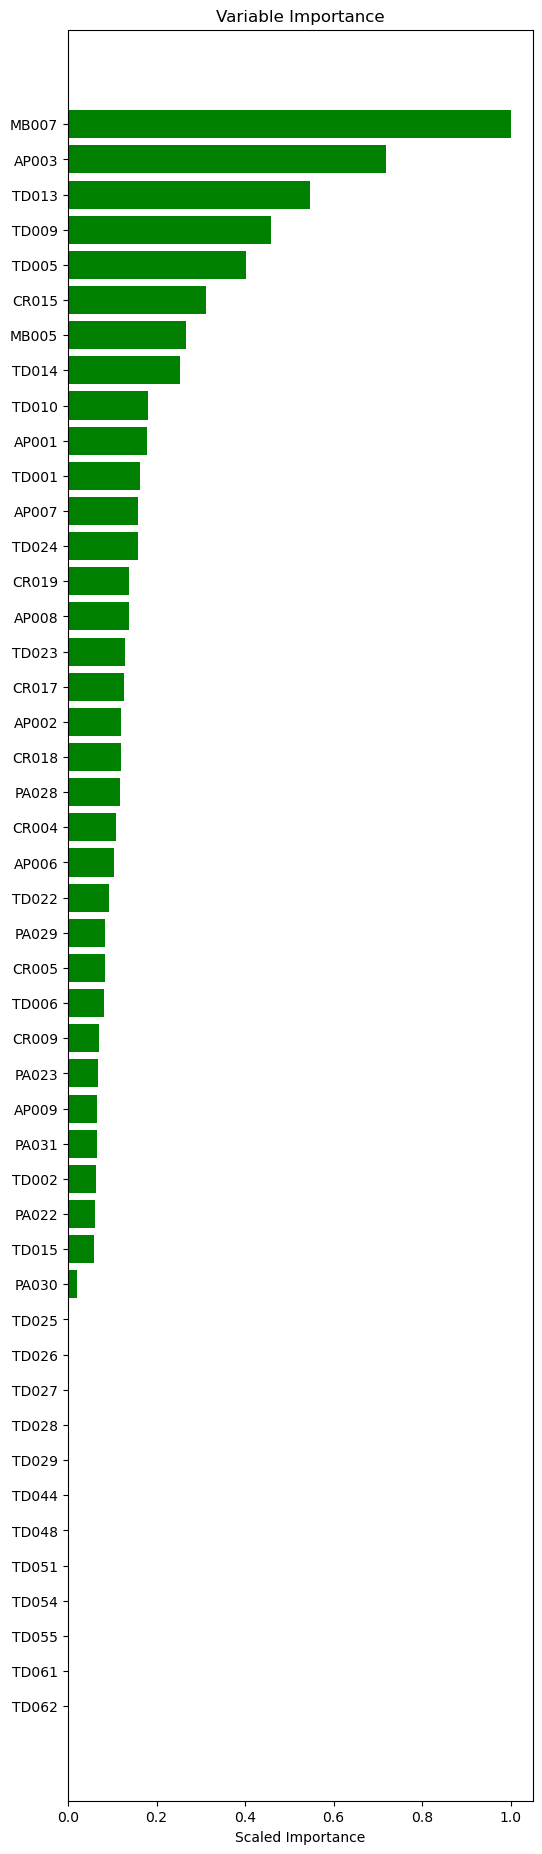

In [29]:
def VarImp(model_name):
    
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    
    # plot the variable importance
    plt.rcdefaults()
    variables = model_name._model_json['output']['variable_importances']['variable']
    y_pos = np.arange(len(variables))
    fig, ax = plt.subplots(figsize = (6,len(variables)/2))
    scaled_importance = model_name._model_json['output']['variable_importances']['scaled_importance']
    ax.barh(y_pos,scaled_importance,align='center',color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)
    ax.invert_yaxis()
    ax.set_xlabel('Scaled Importance')
    ax.set_title('Variable Importance')
    plt.show()

VarImp(gbm_v2)

In [30]:
predictions2 = gbm_v2.predict(test_hex2)
predictions2.head()
test_scores2 = test_hex2['loan_default'].cbind(predictions2).as_data_frame()
test_scores2.head()

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,loan_default,predict
0,0,0.144926
1,0,0.182285
2,0,0.114604
3,1,0.228231
4,0,0.388832


In [31]:
createGains(gbm_v2)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,107,213,320,107,213,0.18,0.08,60.0,1.78,10.0,33.44
1,320,96,224,640,203,437,0.34,0.17,120.0,1.69,17.0,31.72
2,320,70,250,960,273,687,0.46,0.26,180.0,1.52,20.0,28.44
3,320,71,249,1280,344,936,0.57,0.36,240.0,1.43,21.0,26.88
4,320,66,254,1600,410,1190,0.68,0.46,300.0,1.37,22.0,25.62
5,320,57,263,1920,467,1453,0.78,0.56,360.0,1.30,22.0,24.32
6,320,54,266,2240,521,1719,0.87,0.66,420.0,1.24,21.0,23.26
7,320,38,282,2560,559,2001,0.93,0.77,480.0,1.16,16.0,21.84
8,320,23,297,2880,582,2298,0.97,0.88,540.0,1.08,9.0,20.21


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



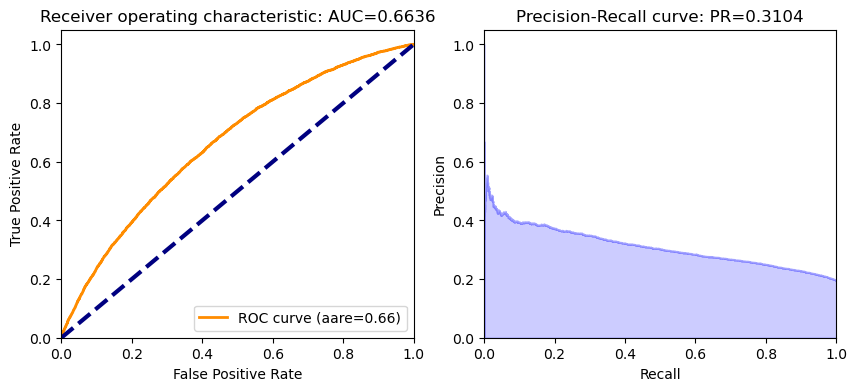

In [32]:
ROC_AUC(gbm_v2,test_hex2,'loan_default')

# Interpretations:
1. Decile Analysis:
- In the first decile, I have 320 instances, and the model predicted 107 actual positive cases. The lift is 1.78, indicating that this decile is 1.78 times more likely to contain actual positive cases than random chance.
- The K-S value of 10.0 suggests decent discrimination between positive and negative cases.

2. Variable Importance:
- "MB007" is the most important variable. This means that changes in "MB007" have the most significant impact on the model's predictions.

3. Scoring History:
- The training process involved building 200 trees.
- AUC is 0.6636, indicating some level of discrimination between positive and negative instances.

# Deep Learning


Deep learning is a subfield of machine learning that focuses on neural networks with many layers, also known as deep neural networks. These networks are capable of learning intricate hierarchical representations of data. Deep learning is used for anomaly detection because of its capacity to automatically learn intricate patterns and representations from data, making it well-suited for detecting anomalies in various types of datasets.

### testing on 10% of the data

In [33]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
DL_modl = H2ODeepLearningEstimator(
    distribution="tweedie",
    activation="RectifierWithDropout",
    hidden=[32,32,32],
    input_dropout_ratio=0.2,
    sparse=True,
    l1=1e-5,
    epochs=10)

DL_modl.train(
    x=predictors,
    y=target,
    training_frame=train_hex,
    validation_frame=test_hex)

deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_model_python_1701310331368_6


Status of Neuron Layers: predicting loan_default, regression, tweedie distribution, Automatic loss, 4,705 weights/biases, 66.6 KB, 48,000 training samples, mini-batch size 1
    layer    units    type              dropout    l1     l2    mean_rate              rate_rms                momentum    mean_weight             weight_rms           mean_bias            bias_rms
--  -------  -------  ----------------  ---------  -----  ----  ---------------------  ----------------------  ----------  ----------------------  -------------------  -------------------  -----------------------
    1        79       Input             20.0
    2        32       RectifierDropout  50.0       1e-05  0.0   0.1376270632629804     0.34510934352874756     0.0         -0.002398803620683828   0.12975263595581055  0.4870877375903571   0.023976273834705353
    3        32       RectifierDropout  50.0       1e-05  0.0   0.002207400581028196   0.0014900192618370056   0.0         -0.0058973555083490226  0.1811550259590149   0.940661504728435    0.0895695686340332
    4        32       RectifierDropout  50.0       1e-05  0.0   0.005696540332536415   0.008532315492630005    0.0         -0.03223017337716638    0.19046849012374878  0.9261056918195557   0.17014753818511963
    5        1        Linear                       1e-05  0.0   0.0002800514389491582  0.00010405623470433056  0.0         -0.08854828332550824    0.14387774467468262  -0.5678494481529263  1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.14802044427655284
RMSE: 0.38473425149907414
MAE: 0.3101961585763782
RMSLE: 0.2726770434945739
Mean Residual Deviance: 1.912170253829843

ModelMetricsRegression: deeplearning
** Reported on validation data. **

MSE: 0.14864807452360793
RMSE: 0.3855490559236372
MAE: 0.3126388361972462
RMSLE: 0.27392069476499187
Mean Residual Deviance: 1.9201691383914374

Scoring History: 
    timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_deviance    training_mae    training_r2    validation_rmse    validation_deviance    validation_mae    validation_r2
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  -------------------  --------------  -------------  -----------------  ---------------------  ----------------  ---------------
    2023-11-30 13:54:13  0.000 sec                     0         0             0          nan              nan                  nan             nan            nan                nan                    nan               nan
    2023-11-30 13:54:13  1.268 sec   10762 obs/sec     1         1             4800       0.388005         1.94142              0.305601        0.0134731      0.388456           1.94771                0.306441          0.00948993
    2023-11-30 13:54:14  2.247 sec   40133 obs/sec     10        10            48000      0.384734         1.91217              0.310196        0.0300356      0.385549           1.92017                0.312639          0.0242588

Variable Importances: 
variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
MB007.KONKA        0.994293212890625      1.0                  0.016288400387014176
PA031              0.9737887978553772     0.9793778990247384   0.015952499349507678
PA023              0.9509357213973999     0.9563936563871581   0.01557812280283449
TD013              0.9354487061500549     0.9408177527738559   0.015324416248391481
MB007.HISENSE      0.9258930683135986     0.931207269957951    0.015167876856373502
MB007.BIRD         0.9174807667732239     0.9227466856641908   0.015030067471888653
TD044.nan          0.9143511652946472     0.9195991217082041   0.01497879868992981
AP006.ios          0.9136965274810791  

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



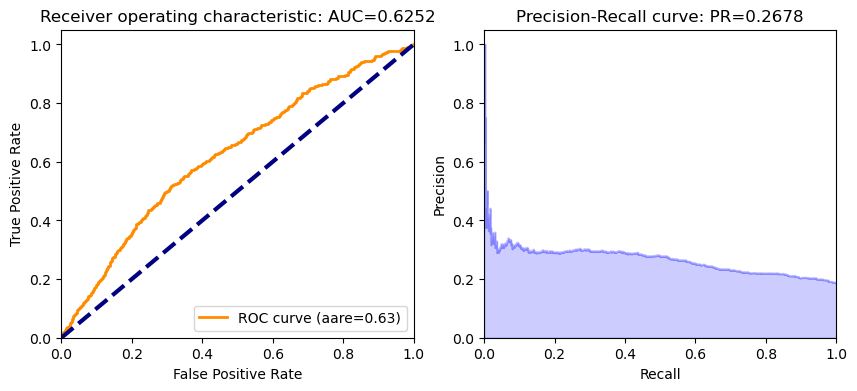

In [34]:
ROC_AUC(DL_modl,test_hex,'loan_default')

In [35]:
createGains(DL_modl)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,93,227,320,93,227,0.16,0.09,60.0,1.55,7.0,29.06
1,320,95,225,640,188,452,0.31,0.17,120.0,1.57,14.0,29.38
2,320,83,237,960,271,689,0.45,0.26,180.0,1.51,19.0,28.23
3,320,64,256,1280,335,945,0.56,0.36,240.0,1.40,20.0,26.17
4,320,53,267,1600,388,1212,0.65,0.47,300.0,1.29,18.0,24.25
5,320,47,273,1920,435,1485,0.72,0.57,360.0,1.21,15.0,22.66
6,320,55,265,2240,490,1750,0.82,0.67,420.0,1.17,15.0,21.88
7,320,41,279,2560,531,2029,0.88,0.78,480.0,1.11,10.0,20.74
8,320,41,279,2880,572,2308,0.95,0.89,540.0,1.06,6.0,19.86


# Best Model Using Grid-Search

In [37]:
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
hyperparams = {
    'hidden': [[32, 32, 32], [64, 64]],
    'input_dropout_ratio': [0.2, 0.4, 0.6],
    'l1': [1e-2, 1e-3, 1e-4],
    'epochs': [10, 20, 30]
}

dl_model_test = H2ODeepLearningEstimator(distribution="tweedie", activation="RectifierWithDropout", sparse=True)

# Perform grid search
grid = H2OGridSearch(dl_model_test, hyperparams)
grid.train(x=predictors, y=target, training_frame=train_hex)

deeplearning Grid Build progress: |██████████████████████████████████████████████| (done) 100%
Errors/Warnings building gridsearch model

Hyper-parameter: epochs, 20.0
Hyper-parameter: hidden, [32, 32, 32]
Hyper-parameter: input_dropout_ratio, 0.2
Hyper-parameter: l1, 0.01
failure_details: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation values.
Try a different initial distribution, a bounded activation function (Tanh), adding regularization
(via max_w2, l1, l2, dropout) or learning rate (either enable adaptive_rate or use a smaller learning rate or faster annealing).

For more information visit:
  https://github.com/h2oai/h2o-3/discussions/15515'
failure_stack_traces: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to obser

,epochs,hidden,input_dropout_ratio,l1,model_ids,residual_deviance
,20.0,"[64, 64]",0.2,0.0001,Grid_DeepLearning_Key_Frame__upload_86be2532574f4ef88a2baf4c40df4b01.hex_model_python_1701310331368_7_model_41,1.8846613
,30.0,"[64, 64]",0.2,0.001,Grid_DeepLearning_Key_Frame__upload_86be2532574f4ef88a2baf4c40df4b01.hex_model_python_1701310331368_7_model_24,1.8856954
,30.0,"[32, 32, 32]",0.2,0.001,Grid_DeepLearning_Key_Frame__upload_86be2532574f4ef88a2baf4c40df4b01.hex_model_python_1701310331368_7_model_21,1.8881538
,30.0,"[32, 32, 32]",0.2,0.0001,Grid_DeepLearning_Key_Frame__upload_86be2532574f4ef88a2baf4c40df4b01.hex_model_python_1701310331368_7_model_39,1.8892415
,10.0,"[64, 64]",0.2,0.001,Grid_DeepLearning_Key_Frame__upload_86be2532574f4ef88a2baf4c40df4b01.hex_model_python_1701310331368_7_model_22,1.8917732
,30.0,"[64, 64]",0.4,0.0001,Grid_DeepLearning_Key_Frame__upload_86be2532574f4ef88a2baf4c40df4b01.hex_model_python_1701310331368_7_model_48,1.8918922
,30.0,"[64, 64]",0.2,0.0001,Grid_DeepLearning_Key_Frame__upload_86be2532574f4ef88a2baf4c40df4b01.hex_model_python_1701310331368_7_model_42,1.8941014
,20.0,"[64, 64]",0.4,0.001,Grid_DeepLearning_Key_Frame__upload_86be2532574f4ef88a2baf4c40df4b01.hex_model_python_1701310331368_7_model_29,1.8958089
,20.0,"[32, 32, 32]",0.2,0.001,Grid_DeepLearning_Key_Frame__upload_86be2532574f4ef88a2baf4c40df4b01.hex_model_python_1701310331368_7_model_20,1.8966451
,10.0,"[64, 64]",0.4,0.0001,Grid_DeepLearning_Key_Frame__upload_86be2532574f4ef88a2baf4c40df4b01.hex_model_python_1701310331368_7_model_46,1.8966491


In [38]:
best_roc_index = 0
best_pr_index = 0
best_roc_auc = 0
best_pr_score = 0
for i in range(len(grid.get_grid())):
  inter_grid=grid.get_grid()[i]

# Evaluate ROC AUC
  roc_auc = ROC_AUC_index(inter_grid, test_hex, target)
  if roc_auc > best_roc_auc:
      best_roc_auc = roc_auc
      best_roc_index = i

# Evaluate PR index
  pr_score = PR_index(inter_grid, test_hex, target)
  if pr_score > best_pr_score:
      best_pr_score = pr_score
      best_pr_index = i

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |███████████████

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


In [39]:
# Print the results
print("best_roc_index:", best_roc_index)
print("Best roc Score:", best_roc_auc)
print("Best PR Index:", best_pr_index)
print("Best PR Score:", best_pr_score)

best_roc_index: 33
Best roc Score: 0.6368211538461538
Best PR Index: 1
Best PR Score: 0.2742326947226517


In [40]:
best_DL_model = grid.get_grid()[33]
best_DL_model

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: Grid_DeepLearning_Key_Frame__upload_86be2532574f4ef88a2baf4c40df4b01.hex_model_python_1701310331368_7_model_6


Status of Neuron Layers: predicting loan_default, regression, tweedie distribution, Automatic loss, 9,345 weights/biases, 119.0 KB, 144,000 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate              rate_rms               momentum    mean_weight             weight_rms           mean_bias            bias_rms
--  -------  -------  ----------------  ---------  ----  ----  ---------------------  ---------------------  ----------  ----------------------  -------------------  -------------------  -----------------------
    1        79       Input             20.0
    2        64       RectifierDropout  50.0       0.01  0.0   0.15688490753655923    0.36857008934020996    0.0         -0.0008969061211330035  0.10405483841896057  0.404815824678334    0.05282965302467346
    3        64       RectifierDropout  50.0       0.01  0.0   0.005948550579745415   0.008709151297807693   0.0         -0.00955766513166197    0.09492871165275574  0.6960636939706579   0.2675286531448364
    4        1        Linear                       0.01  0.0   0.0005669005795425619  0.0008644287008792162  0.0         -0.043030017658644226   0.10804599523544312  -0.2564539631381814  1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.14958641307334394
RMSE: 0.38676402763615947
MAE: 0.27785752991312385
RMSLE: 0.2667697184417823
Mean Residual Deviance: 1.9231822727200325

Scoring History: 
    timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_deviance    training_mae    training_r2
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  -------------------  --------------  -------------
    2023-11-30 13:55:21  0.000 sec                     0         0             0          nan              nan                  nan             nan
    2023-11-30 13:55:22  18.850 sec  28402 obs/sec     3         1             14400      0.386764         1.92318              0.277858        0.0197739
    2023-11-30 13:55:25  21.184 sec  51410 obs/sec     30        10            144000     0.386886         1.92901              0.303901        0.0191571
    2023-11-30 13:55:25  21.431 sec  51373 obs/sec     30        10            144000     0.386764         1.92318              0.277858        0.0197739

Variable Importances: 
variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ---------------------
MB007.UOOGOU       1.0                    1.0                  0.01803666752362221
MB007.DOOV         0.990606427192688      0.990606427192688    0.017867238774037786
MB007.SONY         0.9717357754707336     0.9717357754707336   0.017526875102974827
MB007.HONOR        0.9646168351173401     0.9646168351173401   0.01739847314270017
MB007.MEITU        0.9568673372268677     0.9568673372268677   0.017258698025774708
MB007.MEDIATEK     0.9385560154914856     0.9385560154914856   0.016928422803715544
MB007.CHANGHONG    0.9292545914649963     0.9292545914649963   0.016760656111053526
MB007.MEIZU        0.9284326434135437     0.9284326434135437   0.016745830907327786
MB007.IPHONE7      0.9221110343933105     0.9221110343933105   0.01663181014721551
MB007.IPHONE6      0.9197639226913452     0.9197639226913452   0.01658947607380636
---                ---                    ---                  ---
CR009              0.4732353389263153     0.4732353389263153   0.008535588468642621
PA023              0.41346412897109985    0.41346412897109985  0.007457515027195783
PA030              0.39186665415763855    0.39186665415763855  0.007067968554635576
PA029              0.3631591498851776     0.3631591498851776 

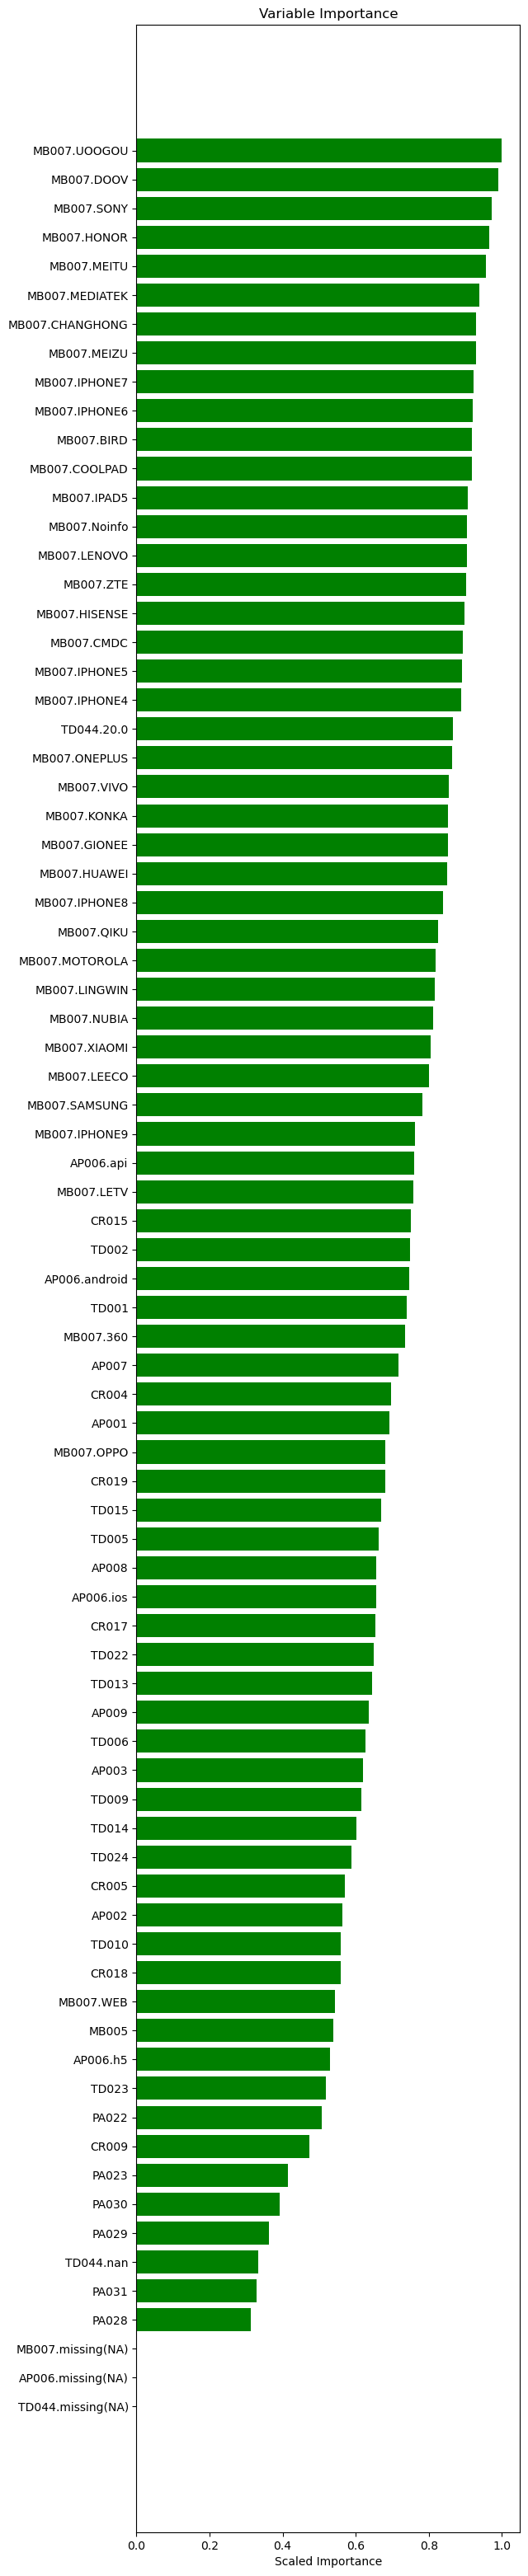

In [41]:
VarImp(best_DL_model)

In [42]:
createGains(best_DL_model)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,101,219,320,101,219,0.17,0.08,60.0,1.68,9.0,31.56
1,320,89,231,640,190,450,0.32,0.17,120.0,1.58,15.0,29.69
2,320,84,236,960,274,686,0.46,0.26,180.0,1.52,20.0,28.54
3,320,64,256,1280,338,942,0.56,0.36,240.0,1.41,20.0,26.41
4,320,59,261,1600,397,1203,0.66,0.46,300.0,1.32,20.0,24.81
5,320,49,271,1920,446,1474,0.74,0.57,360.0,1.24,17.0,23.23
6,320,50,270,2240,496,1744,0.83,0.67,420.0,1.18,16.0,22.14
7,320,50,270,2560,546,2014,0.91,0.77,480.0,1.14,14.0,21.33
8,320,34,286,2880,580,2300,0.97,0.88,540.0,1.07,9.0,20.14


deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



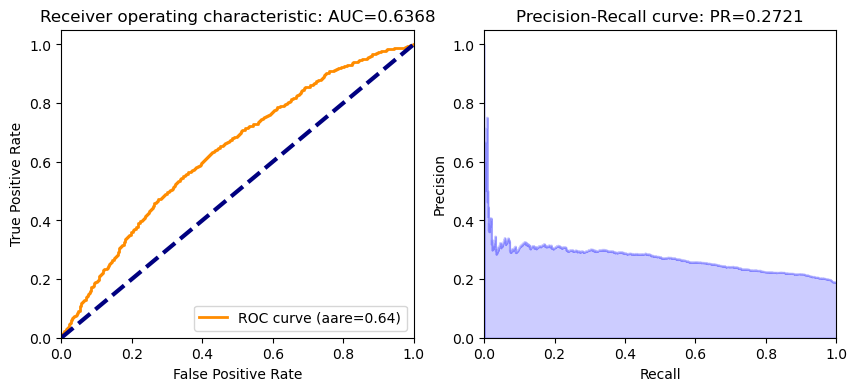

In [43]:
ROC_AUC(best_DL_model,test_hex,'loan_default')

In [44]:
best_DL_model_params = best_DL_model.params
hidden_value = best_DL_model_params['hidden']['actual']
input_dropout_ratio_value = best_DL_model_params['input_dropout_ratio']['actual']
l1_value = best_DL_model_params['l1']['actual']
epochs_value = best_DL_model_params['epochs']['actual']
print("hidden =", hidden_value)
print("input_dropout_ratio =", input_dropout_ratio_value)
print("l1 =", l1_value)
print("epochs =", epochs_value)

hidden = [64, 64]
input_dropout_ratio = 0.2
l1 = 0.01
epochs = 30.0


# DL on the entire dataset

In [45]:
DL_modl2 = H2ODeepLearningEstimator(
    distribution="tweedie",
    activation="RectifierWithDropout",
    hidden=[64,64],
    input_dropout_ratio=0.2,
    sparse=True,
    l1=0.01,
    epochs=30)

DL_modl2.train(
    x=predictors,
    y=target,
    training_frame=train_hex2,
    validation_frame=test_hex2)


deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_model_python_1701310331368_8


Status of Neuron Layers: predicting loan_default, regression, tweedie distribution, Automatic loss, 13,889 weights/biases, 175.6 KB, 1,489,757 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate             rate_rms              momentum    mean_weight            weight_rms            mean_bias             bias_rms
--  -------  -------  ----------------  ---------  ----  ----  --------------------  --------------------  ----------  ---------------------  --------------------  --------------------  -----------------------
    1        150      Input             20.0
    2        64       RectifierDropout  50.0       0.01  0.0   0.26415167916582655   0.4054527282714844    0.0         -0.007007269859364616  0.07934063673019409   0.02069906579408362   0.08122152090072632
    3        64       RectifierDropout  50.0       0.01  0.0   0.030180956458409014  0.013847753405570984  0.0         -0.008624040195080037  0.036095619201660156  0.007186225816542409  0.06931126117706299
    4        1        Linear                       0.01  0.0   0.018969494491784644  0.010947506874799728  0.0         -0.03099209821404081   0.18153661489486694   -1.4917399708346304   1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.15287655506915254
RMSE: 0.39099431590389205
MAE: 0.2966055859531016
RMSLE: 0.2714290651073722
Mean Residual Deviance: 1.9283729851432747

ModelMetricsRegression: deeplearning
** Reported on validation data. **

MSE: 0.1537920201000805
RMSE: 0.39216325694802223
MAE: 0.2976404768401809
RMSLE: 0.272250628942976
Mean Residual Deviance: 1.9341810725969593

Scoring History: 
    timestamp            duration    training_speed    epochs    iterations    samples      training_rmse    training_deviance    training_mae    training_r2    validation_rmse    validation_deviance    validation_mae    validation_r2
--  -------------------  ----------  ----------------  --------  ------------  -----------  ---------------  -------------------  --------------  -------------  -----------------  ---------------------  ----------------  ---------------
    2023-11-30 14:03:31  0.000 sec                     0         0             0            nan              nan                  nan             nan            nan                nan                    nan               nan
    2023-11-30 14:03:34  6.512 sec   31933 obs/sec     1.82952   1             87817        0.391718         1.94456              0.32463         0.0173955      0.39258            1.94678                0.325293          0.0162795
    2023-11-30 14:03:57  26.778 sec  66120 obs/sec     31.0366   17            1.48976e+06  0.390994         1.92837              0.296606        0.0210248      0.392163           1.93418                0.29764           0.0183681

Variable Importances: 
variable           relative_importance    scaled_importance     percentage
-----------------  ---------------------  --------------------  ---------------------
MB007.BIRD         0.9625518321990967     1.0                   0.011779149537134131
MB007.BOWAY        0.954227089881897      0.9913513828152188    0.011677276182025166
MB007.IPAD5        0.9442105293273926     0.9809451270485865    0.01155469933922834
MB007.YTONE_L985   0.9237851500511169     0.9597250965078823    0.011304745426306832
MB007.SGMSGMS      0.9216615557670593     0.9575188835923596    0.011278758114464134
MB007.GOOGLE       0.9070917963981628     0.9423822863915526    0.011100461872552462
MB007.DAQ          0.8922799229621887     0.9269941556535599    0.010919202779492676
TD051.20.0         0.8867897987365723     0.9212904376386314    0.010852017832077187
MB007.MEDIATEK     0.881371021270752      0.9156608421357687    0.010785705984815389
MB007.360          0.8716870546340942     0.9056001198840296    0.010

In [46]:
predictions4 = DL_modl2.predict(test_hex2)
predictions4.head()
predictions4 = test_hex2['loan_default'].cbind(predictions4).as_data_frame()
predictions4.head()

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


,loan_default,predict
0,0,0.164087
1,0,0.169568
2,0,0.154203
3,1,0.179073
4,0,0.224981


In [47]:
createGains(DL_modl2)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,104,216,320,104,216,0.17,0.08,60.0,1.73,9.0,32.50
1,320,91,229,640,195,445,0.32,0.17,120.0,1.62,15.0,30.47
2,320,73,247,960,268,692,0.45,0.27,180.0,1.49,18.0,27.92
3,320,69,251,1280,337,943,0.56,0.36,240.0,1.40,20.0,26.33
4,320,57,263,1600,394,1206,0.66,0.46,300.0,1.31,20.0,24.62
5,320,51,269,1920,445,1475,0.74,0.57,360.0,1.24,17.0,23.18
6,320,58,262,2240,503,1737,0.84,0.67,420.0,1.20,17.0,22.46
7,320,44,276,2560,547,2013,0.91,0.77,480.0,1.14,14.0,21.37
8,320,30,290,2880,577,2303,0.96,0.89,540.0,1.07,7.0,20.03


deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



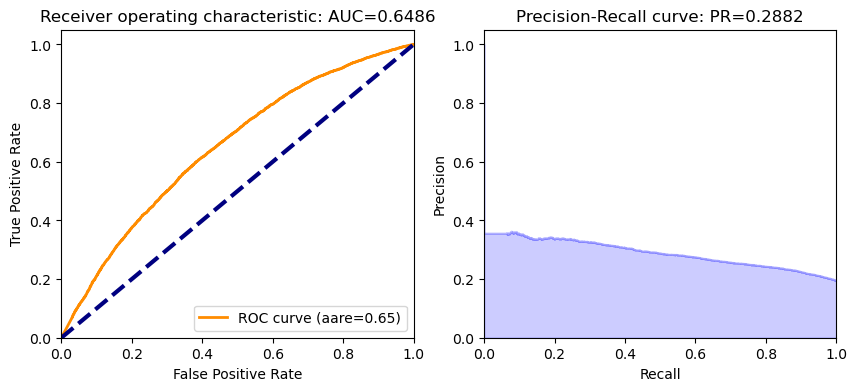

In [48]:
ROC_AUC(DL_modl2,test_hex2,'loan_default')

# Interpretations:
1. Decile Analysis:
- In the first decile, I have 320 instances, and the model predicted 104 actual positive cases. The lift is 1.73, indicating that this decile is 1.73 times more likely to contain actual positive cases than random chance.
- The K-S value of 9.0 suggests decent discrimination between positive and negative cases.

2. Variable Importance:
- "MB007" is the most important variable. This means that changes in "MB007" have the most significant impact on the model's predictions.

3. Scoring History:
- AUC is 0.6486, indicating some level of discrimination between positive and negative instances.